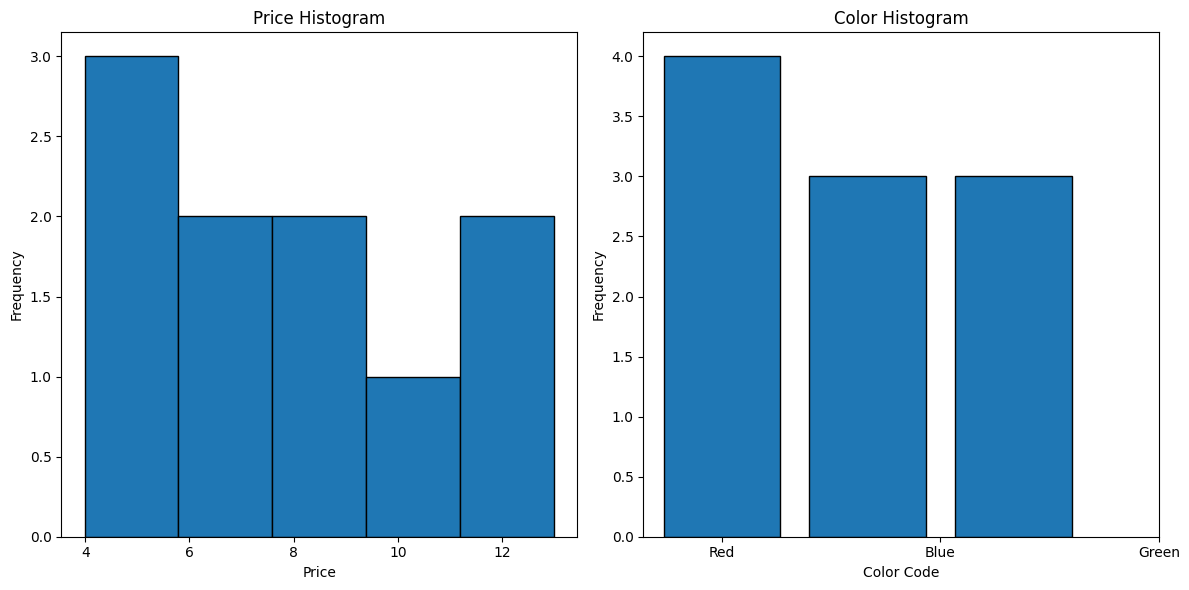

In [3]:
# main_notebook.ipynb

# Cell 1: Imports and Setup
import os
import shutil
from IPython.display import display, Markdown, Image as IPImage, clear_output
import ipywidgets as widgets
from PIL import Image as PILImage # Renamed to avoid conflict
import io
import base64
import pandas as pd # For displaying DataFrames nicely
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Import our utility functions
from utils.file_parser import parse_file
from utils.llm_handler import get_llm_response, MODEL_NAME
from utils.code_executor import execute_python_code

# Create necessary directories if they don't exist
os.makedirs("uploads", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# --- Global State (simulating a session) ---
# In a real app, this would be session-specific
current_file_path = None
current_file_content = None
current_file_type = None # 'text', 'dataframe', 'error'
conversation_history = [] # List of {"role": "user/assistant", "content": "message"}
MAX_HISTORY_LEN = 10 # Keep last 5 Q/A pairs (10 messages)

# --- System Prompt for the Agent ---
SYSTEM_PROMPT = f"""You are a helpful Data Analyst Agent. Your name is "Llama Analyst". 
You are using the LLM model: {MODEL_NAME}.
You can analyze data from uploaded files, answer questions about them, and generate Python code for analysis and visualization.

File Context:
- If a file is uploaded, I will provide you with its content or a summary.
- For tabular data (CSV/Excel), I will give you the column names, data types, and the head of the DataFrame. The DataFrame will be available as `df` in the Python execution environment.
- For text-based files (TXT, DOCX, PDF, OCR'd Images), I will provide the extracted text.

Your Task:
1.  Understand the user's question in the context of the provided file data.
2.  If the question is a general greeting or unrelated to data analysis, answer politely.
3.  For questions about textual data: Answer based on the text provided.
4.  For data analysis or visualization requests on tabular data:
    a.  Generate **ONLY Python code** to perform the task.
    b.  The code should use a DataFrame named `df`.
    c.  Available libraries: pandas (as pd), numpy (as np), matplotlib.pyplot (as plt), seaborn (as sns).
    d.  **IMPORTANT FOR PLOTS**: 
        - Generate plots using matplotlib/seaborn. 
        - **DO NOT call `plt.show()`**. The system will capture the plot automatically.
        - Ensure plots have titles and axis labels for clarity.
        - Example plot: `plt.figure(figsize=(10,6)); sns.histplot(df['column_name']); plt.title('Distribution');`
    e.  For analysis that results in data (e.g., mean, count), print the result using `print()`. Example: `print(df['age'].mean())`
    f.  Enclose the Python code **strictly** within triple backticks, like this:
        ```python
        # Your python code here
        print(df.describe())
        ```
5.  If the user's request is ambiguous or you need more information, ask clarifying questions.
6.  If you cannot answer or perform the task, state so clearly and explain why.
7.  Keep your responses concise and to the point.
8.  After I execute your Python code, I will show you the `stdout`, `stderr` (if any), and the generated plot (if any). You can then interpret these results for the user or suggest next steps.
"""

# Add system prompt to history
conversation_history.append({"role": "system", "content": SYSTEM_PROMPT})

# Cell 2: UI Elements (Widgets)
file_upload_widget = widgets.FileUpload(
    accept='.doc, .txt, .xlsx, .csv, .pdf, .png, .jpg, .jpeg',  # Accepted file types
    multiple=False,  # Allow only one file at a time
    description='Upload File'
)

text_input_widget = widgets.Textarea(
    value='',
    placeholder='Ask a question about the uploaded file or general queries...',
    description='Your Query:',
    layout={'width': '80%', 'height': '100px'}
)

submit_button = widgets.Button(
    description='Submit Query',
    button_style='success',
    tooltip='Click to submit your query to the agent'
)

clear_button = widgets.Button(
    description='Clear Conversation',
    button_style='warning',
    tooltip='Clear the conversation history'
)

output_area = widgets.Output() # To display results

# Cell 3: Helper Functions for UI and Agent Logic

def display_message(role, message_content, is_code=False, is_plot_path=None, is_df=False):
    """Display messages with appropriate formatting"""
    with output_area:
        if role == "user":
            display(Markdown(f"👤 **You:** {message_content}"))
        elif role == "assistant":
            if is_plot_path:
                display(Markdown(f"🤖 **Llama Analyst:** Here is the visualization:"))
                try:
                    display(IPImage(filename=is_plot_path))
                except Exception as e:
                    display(Markdown(f"⚠️ Error displaying plot: {str(e)}"))
            elif is_df and isinstance(message_content, pd.DataFrame):
                display(Markdown(f"🤖 **Llama Analyst:** Here's a part of the data:"))
                display(message_content.head()) # Display DataFrame
            elif is_code:
                display(Markdown(f"🤖 **Llama Analyst:** (Generated Code)\n```python\n{message_content}\n```"))
            else:
                display(Markdown(f"🤖 **Llama Analyst:** {message_content}"))
        elif role == "system_code_output":
            display(Markdown(f"⚙️ **Code Output:**\n```\n{message_content}\n```"))
        elif role == "system_error":
             display(Markdown(f"⚠️ **System Error:** {message_content}"))


def add_to_history(role, content):
    """Add message to conversation history with size management"""
    global conversation_history
    conversation_history.append({"role": role, "content": content})
    # Keep history to a manageable size
    if len(conversation_history) > MAX_HISTORY_LEN + 1: # +1 for system prompt
        # Keep system prompt, remove older messages from the middle
        conversation_history = [conversation_history[0]] + conversation_history[-(MAX_HISTORY_LEN):]

def extract_python_code(llm_response):
    """Extract Python code from LLM response"""
    if "```python" in llm_response:
        try:
            code = llm_response.split("```python")[1].split("```")[0].strip()
            return code
        except IndexError:
            return None
    return None

def get_df_summary(df):
    """Creates a string summary of the DataFrame for the LLM."""
    if not isinstance(df, pd.DataFrame):
        return "No DataFrame available or error in loading."
    
    try:
        # Use an in-memory text buffer to capture DataFrame.info()
        buffer = io.StringIO()
        df.info(buf=buffer)
        df_info_str = buffer.getvalue()
        
        summary = f"The DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.\n"
        summary += "Column names, data types, and non-null counts:\n"
        summary += df_info_str + "\n\n"
        summary += "First 5 rows (df.head()):\n"
        summary += df.head().to_string() + "\n"
        
        # Only include describe() if DataFrame is not too large
        if df.shape[0] > 0:
            summary += "Basic descriptive statistics (df.describe()):\n"
            summary += df.describe(include='all').to_string() # include='all' for non-numeric too
        
        return summary
    except Exception as e:
        return f"Error generating DataFrame summary: {str(e)}"

# Cell 4: Event Handlers

def on_file_upload_change(change):
    """Handle file upload events"""
    global current_file_path, current_file_content, current_file_type, conversation_history
    
    # Clear previous file state and relevant history
    current_file_path = None
    current_file_content = None
    current_file_type = None
    # Reset history, but keep system prompt
    conversation_history = [conversation_history[0]] if conversation_history and conversation_history[0]['role'] == 'system' else [{"role": "system", "content": SYSTEM_PROMPT}]

    uploaded_files = file_upload_widget.value
    if not uploaded_files:
        with output_area:
            clear_output(wait=True) # Clear previous outputs
            display(Markdown("No file selected or upload cleared."))
        return

    # Handle the tuple structure of uploaded files
    # uploaded_files is a tuple of FileUpload objects
    if isinstance(uploaded_files, tuple) and len(uploaded_files) > 0:
        uploaded_file = uploaded_files[0]  # Get the first (and only) file
        filename = uploaded_file['name']
        file_content = uploaded_file['content']  # This is in bytes
    else:
        with output_area:
            clear_output(wait=True)
            display_message("system_error", "Invalid file upload format.")
        return

    # Save the uploaded file temporarily to pass its path to parsers
    temp_file_path = os.path.join("uploads", filename)
    try:
        with open(temp_file_path, 'wb') as f:
            f.write(file_content)
        
        current_file_path = temp_file_path # Store path of the saved temp file

        with output_area:
            clear_output(wait=True) # Clear previous outputs
            display(Markdown(f"📄 **File Uploaded:** {filename}"))
            
            content, content_type = parse_file(current_file_path)
            
            if content_type == "error":
                display_message("system_error", content)
                current_file_content = None
                current_file_type = None
            else:
                current_file_content = content
                current_file_type = content_type
                
                if current_file_type == "dataframe":
                    if isinstance(current_file_content, pd.DataFrame):
                        display(Markdown(f"📊 **Data Preview (first 5 rows):**"))
                        display(current_file_content.head())
                        add_to_history("system", f"File '{filename}' uploaded. It's a DataFrame. Summary:\n{get_df_summary(current_file_content)}")
                    else: # Should be an error message from parser
                        display_message("system_error", f"Expected DataFrame but got: {str(current_file_content)}")
                        current_file_content = None # Invalidate
                        current_file_type = "error"
                elif current_file_type == "text":
                    preview_text = current_file_content[:500] if len(current_file_content) > 500 else current_file_content
                    display(Markdown(f"📜 **Text Preview:**\n```\n{preview_text}{'...' if len(current_file_content) > 500 else ''}\n```"))
                    add_to_history("system", f"File '{filename}' uploaded. It's text content. Length: {len(current_file_content)} chars.")
                else:
                    display_message("system_error", f"Unknown content type: {current_file_type}")
    
    except Exception as e:
        with output_area:
            display_message("system_error", f"Error processing file: {str(e)}")
        print(f"Debug - Exception: {e}")
        print(f"Debug - uploaded_files type: {type(uploaded_files)}")
        print(f"Debug - uploaded_files content: {uploaded_files}")


file_upload_widget.observe(on_file_upload_change, names='value')

def on_submit_button_clicked(b):
    """Handle submit button clicks"""
    global conversation_history, current_file_content, current_file_type

    user_query = text_input_widget.value.strip()
    if not user_query:
        with output_area:
            display_message("system_error", "Please enter a query.")
        return

    with output_area: # Display user query immediately
        display_message("user", user_query)
    
    add_to_history("user", user_query)
    text_input_widget.value = "" # Clear input field

    # Get LLM response
    try:
        llm_response_text = get_llm_response(user_query, conversation_history=conversation_history, max_tokens=1500)
        
        if llm_response_text.startswith("Error:"):
            with output_area:
                display_message("system_error", llm_response_text)
            add_to_history("assistant", f"Error occurred: {llm_response_text}")
            return

        add_to_history("assistant", llm_response_text) # Add raw LLM response to history

        # Check if LLM generated Python code
        python_code = extract_python_code(llm_response_text)

        if python_code:
            with output_area:
                display(Markdown("🤖 **Llama Analyst:** I've generated some Python code to address your query. Here it is:"))
                display(Markdown(f"```python\n{python_code}\n```"))
                display(Markdown("⚙️ **Executing code...**"))

            if current_file_type == "dataframe" and isinstance(current_file_content, pd.DataFrame):
                stdout_val, stderr_val, plot_b64 = execute_python_code(python_code, df=current_file_content)
                
                # Display outputs
                if stdout_val:
                    with output_area:
                        display(Markdown(f"**Code Output:**\n```\n{stdout_val}\n```"))
                
                if stderr_val:
                    with output_area:
                        display(Markdown(f"⚠️ **Code Errors:**\n```\n{stderr_val}\n```"))
                
                # Handle plot display
                if plot_b64:
                    plot_filename = f"plot_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.png"
                    plot_save_path = os.path.join("outputs", plot_filename)
                    try:
                        with open(plot_save_path, "wb") as f:
                            f.write(base64.b64decode(plot_b64))
                        with output_area:
                            display(Markdown(f"🖼️ **Generated Plot:** (Saved as {plot_filename})"))
                            display(IPImage(filename=plot_save_path))
                    except Exception as e:
                        with output_area:
                            display_message("system_error", f"Error saving/displaying plot: {str(e)}")

                # Follow-up interpretation if needed
                if stdout_val or stderr_val or plot_b64:
                    interpretation_prompt = f"""The Python code you provided was executed.
Code:
```python
{python_code}
```

Results:
- Output: {stdout_val if stdout_val else 'None'}
- Errors: {stderr_val if stderr_val else 'None'}
- Plot generated: {'Yes' if plot_b64 else 'No'}

Please provide a brief interpretation of these results for the user."""

                    try:
                        interpretation = get_llm_response(interpretation_prompt, conversation_history=conversation_history[-5:], max_tokens=500)
                        if not interpretation.startswith("Error:"):
                            with output_area:
                                display(Markdown(f"🤖 **Llama Analyst:** {interpretation}"))
                    except Exception as e:
                        with output_area:
                            display_message("system_error", f"Error getting interpretation: {str(e)}")
            else:
                with output_area:
                    display_message("system_error", "Code execution requires a DataFrame. Please upload a CSV or Excel file first.")
        else:
            # No code generated, just display the LLM response
            with output_area:
                display_message("assistant", llm_response_text)
                
    except Exception as e:
        with output_area:
            display_message("system_error", f"Error processing query: {str(e)}")

def on_clear_button_clicked(b):
    """Clear conversation history and output"""
    global conversation_history, current_file_content, current_file_type, current_file_path
    
    # Reset global state
    conversation_history = [{"role": "system", "content": SYSTEM_PROMPT}]
    current_file_content = None
    current_file_type = None
    current_file_path = None
    
    # Clear output area
    with output_area:
        clear_output(wait=True)
        display(Markdown("🔄 **Conversation cleared. Ready for new queries!**"))

submit_button.on_click(on_submit_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Cell 5: Display the UI
def create_ui():
    """Create and display the complete UI"""
    ui_box = widgets.VBox([
        widgets.HTML("<h2>🤖 Data Analyst Agent</h2>"),
        widgets.HTML("<p>Upload a file (CSV, Excel, TXT, PDF, etc.) and ask questions about it!</p>"),
        file_upload_widget,
        text_input_widget,
        widgets.HBox([submit_button, clear_button]),
        output_area
    ])
    
    display(ui_box)
    
    # Initial message
    with output_area:
        display(Markdown("👋 **Welcome to Data Analyst Agent!** Upload a file and start asking questions."))

# Cell 6: Initialize the application
if __name__ == "__main__":
    create_ui()